In [2]:
import sys
sys.dont_write_bytecode = True
import torch
import torchaudio
import numpy as np
import logging
from IPython.display import Audio
from datasets import load_dataset
from torchaudio.utils import download_asset
logger = logging.getLogger(__name__)

In [1]:
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoFeatureExtractor,
    AutoProcessor,
    AutoModelForTokenClassification,
    AutoModelForSpeechSeq2Seq,
    AutoModelForCTC,
)

2023-02-27 21:27:03.813395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
config = AutoConfig.from_pretrained("facebook/s2t-small-librispeech-asr")
tokenizer = AutoTokenizer.from_pretrained("facebook/s2t-small-librispeech-asr")
model = AutoModelForSpeechSeq2Seq.from_pretrained("facebook/s2t-small-librispeech-asr", config=config)
processor = AutoProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/s2t-small-librispeech-asr")
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
# print(model)
print(ds[0])

inputs = processor(
    ds[0]["audio"]["array"], 
    sampling_rate=ds[0]["audio"]["sampling_rate"], 
    return_tensors="pt",
) # input_features, attention_mask
input_features = inputs.input_features
print(input_features.shape)
outputs = model.generate(
    inputs=input_features,
    max_length=128,
    output_scores=True,
    return_dict_in_generate=True,
)
print(outputs.keys())
seqs, seq_scores, scores = outputs.sequences, outputs.sequences_scores, outputs.scores
print(seqs)
transcription = processor.batch_decode(seqs, skip_special_tokens=True)[0]
print(transcription)

Found cached dataset librispeech_asr_dummy (/home/monkey/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


{'file': '/home/monkey/.cache/huggingface/datasets/downloads/extracted/882ca765a0dfdf2865144e05b76b1dc54fa85e48d74d8b8ca2d9420063365d25/dev_clean/1272/128104/1272-128104-0000.flac', 'audio': {'path': '/home/monkey/.cache/huggingface/datasets/downloads/extracted/882ca765a0dfdf2865144e05b76b1dc54fa85e48d74d8b8ca2d9420063365d25/dev_clean/1272/128104/1272-128104-0000.flac', 'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
       0.0010376 ], dtype=float32), 'sampling_rate': 16000}, 'text': 'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL', 'speaker_id': 1272, 'chapter_id': 128104, 'id': '1272-128104-0000'}
torch.Size([1, 584, 80])
odict_keys(['sequences', 'sequences_scores', 'scores', 'beam_indices'])
tensor([[   2,  129, 8053,   66,   30,    4, 5878,    8,    4, 1080, 3353,    5,
            6,   52,   60,  534,    9, 1524,   20, 5517,    2]])
mister quilter is the apostle of the middle classes and we are glad to we

In [ ]:
from argparse import Namespace
from uncertainty import convert_dropouts, activate_mc_dropout

committee_size = 10
data_uncertainty = "entropy"
model_uncertainty = "bald"
dropout_args = Namespace(
    max_n=100,
    max_frac=0.4,
    mask_name="mc",
    dry_run_dataset="train",
)
uncertainty_args = Namespace(
    dropout_type="MC",
    data_ue_type=data_uncertainty,
    inference_prob=0.1,
    committee_size=committee_size,  # number of forward passes
    dropout_subs="last",
    eval_bs=1000,
    use_cache=True,
    eval_passes=False,
    dropout=dropout_args,
)

# a = [torch.rand(20, 10000), torch.rand(24, 10000), torch.rand(16, 10000)]
# batch_scores = processor.feature_extractor.pad(a, return_tensors="pt")
print(tokenizer.special_tokens_map)
print(tokenizer.all_special_ids)
print(tokenizer.all_special_tokens)
print(tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.unk_token_id, tokenizer.pad_token_id)
input_features = torch.rand(3, 20, 80)
convert_dropouts(model, uncertainty_args)
activate_mc_dropout(model, activate=True, random=uncertainty_args.inference_prob)

dropout_eval_results = {}
dropout_eval_results["sampled_probabilities"] = []
for _ in range(committee_size):
    outputs = model.generate(
        inputs=input_features,
        max_length=128,
        output_scores=True,
        return_dict_in_generate=True,
    )
    scores = outputs.scores
    # print("scores[0]: {}".format(scores[0]))
    print("seqs: {}".format(outputs.sequences))

activate_mc_dropout(model, activate=False)
logger.info("*******Done!!!*******")

In [ ]:
gpt2tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2tokenizer.pad_token = tokenizer.eos_token
gpt2 = AutoModelForTokenClassification.from_pretrained("gpt2")

inputs = ['I love this place', 'I hate this place']
inputs = gpt2tokenizer(inputs, return_tensors="pt", padding=True)
print(inputs)

convert_dropouts(gpt2, uncertainty_args)
activate_mc_dropout(gpt2, activate=True, random=uncertainty_args.inference_prob)

dropout_eval_results = {}
dropout_eval_results["sampled_probabilities"] = []
for _ in range(committee_size):
    outputs = gpt2(**inputs)
    print("logits: {}".format(outputs.logits))

activate_mc_dropout(gpt2, activate=False)
logger.info("*******Done!!!*******")

In [ ]:
SAMPLE_NOISE = "tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav"
noise_file = download_asset(SAMPLE_NOISE)
noise, sample_rate = torchaudio.load(noise_file)
print(noise.shape, sample_rate)
Audio(noise, rate=sample_rate)

In [ ]:
# processor = AutoProcessor.from_pretrained("facebook/wav2vec2-xls-r-300m-en-to-15")
# model = AutoModelForSpeechSeq2Seq.from_pretrained("facebook/wav2vec2-xls-r-300m-en-to-15")
# ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
# print(ds[0])

# input_values = processor(
#     ds[0]["audio"]["array"], 
#     return_tensors="pt").input_values
# print(input_values.shape)
# # Inference: Translate English speech to German
# generated = model.generate(input_values)
# decoded = processor.batch_decode(generated, skip_special_tokens=True)[0]
# print(decoded)

# # Training: Train model on English transcription
# labels = processor(text=ds[0]["text"], return_tensors="pt").input_ids
# loss = model(input_values, labels=labels).loss
# loss.backward()

In [ ]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
model = AutoModelForCTC.from_pretrained("facebook/hubert-large-ls960-ft")

# audio file is decoded on the fly
inputs = processor(
    str(dataset[0]["audio"]["array"]), 
    sampling_rate=sampling_rate, 
    return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
predicted_ids = torch.argmax(logits, dim=-1)

# transcribe speech
transcription = processor.batch_decode(predicted_ids)
print(transcription[0])

# inputs["labels"] = processor(text=dataset[0]["text"], return_tensors="pt").input_ids
# # compute loss
# loss = model(**inputs).loss
# round(loss.item(), 2)

In [ ]:
model

In [ ]:
audio_1 = "LibriSpeech/test-clean/1089/134686/1089-134686-0030.flac"
# model = "asr-crdnn-rnnlm-librispeech" 
# model = "asr-transformer-transformerlm-librispeech"
# model = "asr-transformer-transformerlm-librispeech"
# model = "asr-wav2vec2-librispeech"
model = "asr-wav2vec2-commonvoice-fr"

# # Uncomment for using another pre-trained model
# asr_model = EncoderASR.from_hparams(
#     source=f"speechbrain/{model}", 
#     savedir=f"pretrained_models/{model}", 
#     # run_opts={"device":"cuda"}, # inference on GPU
#     hparams_file="hyperparams.yaml",
# )
# asr_model.transcribe_file(audio_1)

asr_model = EncoderASR.from_hparams(
    source="speechbrain/asr-wav2vec2-commonvoice-fr",
    savedir=f"pretrained_models/{model}",
) 
asr_model.transcribe_file("samples/audio_samples/example_fr.wav") 

In [ ]:
# asr_model (EncoderDecoderASR)
# mods: ModuleDict(InputNormalization, Encoder, Decoder, LM)
    # Encoder: LengthsCapableSequential
    # Decoder: S2SRNNBeamSearchTransformerLM
    # LM: TransformerLM
from speechbrain.nnet.containers import LengthsCapableSequential
from speechbrain.decoders import S2SRNNBeamSearchLM, S2SRNNBeamSearchTransformerLM
from speechbrain.lobes.models.transformer.TransformerLM import TransformerLM

return_log_probs = True
emb = torch.nn.Embedding(5, 3)
dec = sb.nnet.RNN.AttentionalRNNDecoder(
    "gru", "content", 3, 3, 1, enc_dim=7, input_size=3
)
lin = sb.nnet.linear.Linear(n_neurons=5, input_size=3)
lm = TransformerLM(5, 512, 8, 1, 0, 1024, activation=torch.nn.GELU)
searcher = S2SRNNBeamSearchTransformerLM(
    embedding=emb,
    decoder=dec,
    linear=lin,
    language_model=lm,
    bos_index=4,
    eos_index=4,
    blank_index=4,
    min_decode_ratio=0,
    max_decode_ratio=1,
    beam_size=2,
    lm_weight=0.5,
    return_log_probs=return_log_probs,
)
enc = torch.rand([2, 6, 7]) # B X T X D
wav_len = torch.rand([2]) # B
outputs = searcher(enc, wav_len)
if return_log_probs:
    predictions, topk_scores, log_probs = outputs
    print("log-probs: ", log_probs)
else:
    predictions, topk_scores = outputs
print("predictions: ", predictions)
print("topk_scores: ", topk_scores)

In [ ]:
audio_1 = "LibriSpeech/test-clean/1089/134686/1089-134686-0029.flac"
waveform = asr_model.load_audio(audio_1)
# Fake a batch
batch = waveform.unsqueeze(0)
print('wave tensor: ', batch.shape)
rel_length = torch.tensor([1.0])
# predicted_words, predicted_tokens = asr_model.transcribe_batch(batch, rel_length)
with torch.no_grad():
    wav_lens = rel_length
    encoder_out = asr_model.encode_batch(batch, wav_lens) # B X T X D
    print(encoder_out.shape)
    predicted_tokens, scores, log_probs = asr_model.mods.decoder(encoder_out, wav_lens)
    print([len(tokens) for tokens in predicted_tokens])
    print("scores: ", scores.shape)
    print("log_probs: ", [log_prob.shape for log_prob in log_probs])
    predicted_words = [
        asr_model.tokenizer.decode_ids(token_seq)
        for token_seq in predicted_tokens
    ]
    print(predicted_words)

In [ ]:
preds1 = 'BEWARE OF MAKING THAT MISTAKE'
preds2 = 'GIVE NOT SO EARNEST A MIND TO THESE MUMMERIES CHILD'

In [ ]:
asr_model.tokenizer.decode_ids([224, 336, 11, 53, 90, 32, 66, 49])

In [ ]:
import re
f1 = open("LibriSpeech-asr-crdnn-rnnlm-librispeech-energy.log", "r")
f2 = open("LibriSpeech-asr-crdnn-transformerlm-librispeech-energy.log", "r")

def get_XY(f):
    unit = "mW"
    inss, avgs = [], []
    for line in f:
        r = re.compile('VDD_GPU_SOC (.+?)([ \.]|$)')
        patterns = re.findall(r, line)
        if not patterns:
            continue
        GPU_pair = patterns[0][0]
        ins, avg = GPU_pair.split('/')
        ins = int(ins.rstrip(unit))
        inss.append(ins)
        avg = int(avg.rstrip(unit))
        avgs.append(avg)
    return inss, avgs

inss1, avgs1 = get_XY(f1)
inss2, avgs2 = get_XY(f2)

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

xx2 = np.arange(len(inss2))
yy2 = np.array(inss2)
plt.plot(xx2, yy2, label='CRDNN + TransLM')
plt.fill_between(xx2, yy2, y2 = min(yy2), alpha=0.3,)
xx1 = np.arange(len(inss1))
yy1 = np.array(inss1)
plt.plot(xx1, yy1, label='CRDNN + RNNLM')
plt.fill_between(xx1, yy1, y2 = min(yy1), alpha=0.3,)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(
    {
        'Energy': [min(inss2[2:]), min(inss1[2:]), np.mean(inss2[1:]), np.mean(inss1[1:]), max(inss2[1:]), max(inss1[1:])],
        'Model': ['CRDNN + TransLM', 'CRDNN + RNNLM']*3,
    }
)
print(df)
f = plt.figure(figsize=(4.5, 6))
ax = sns.boxplot(x='Model', y='Energy', data=df, hue='Model', dodge=False, width=0.5)

### Add noise

In [ ]:
SAMPLE_WAV = "LibriSpeech/test-clean/1089/134686/1089-134686-0030.flac"
# SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
print(SAMPLE_WAV)
waveform = asr_model.load_audio(SAMPLE_WAV).unsqueeze(0)

print(waveform)
plot_waveform(waveform, 16000)
Audio(waveform, rate=16000)

In [ ]:
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")
# noise, noise_sample_rate = torchaudio.load(SAMPLE_NOISE)
noise = asr_model.load_audio(SAMPLE_NOISE).unsqueeze(0)
print(noise.shape)
plot_waveform(noise, 16000)
Audio(noise, rate=16000)

In [ ]:
from math import ceil
# Handle noise
if noise.shape[1] < waveform.shape[1]:
    K = ceil(waveform.shape[1] / noise.shape[1])
    noi = noise.repeat(1, K)[:, :waveform.shape[1]]
else:
    noi = noise[:, :waveform.shape[1]]

print(waveform.shape, noi.shape)
snr_dbs = torch.tensor([20, 10, 3])
noisy_speech = add_noise(waveform, noi, snr_dbs)
print(noisy_speech.shape)
plot_waveform(noisy_speech.mean(dim=0).unsqueeze(0), 16000)
Audio(noisy_speech.mean(dim=0).unsqueeze(0), rate=16000)
# noisy_speech = waveform + noi
# print(noisy_speech)
# plot_waveform(noisy_speech, 16000)
# Audio(noisy_speech, rate=16000)

In [ ]:
import torch
from typing import Optional

def add_noise(
    waveform: torch.Tensor, noise: torch.Tensor, snr: torch.Tensor, lengths: Optional[torch.Tensor] = None
) -> torch.Tensor:
    if not (waveform.ndim - 1 == noise.ndim - 1 == snr.ndim and (lengths is None or lengths.ndim == snr.ndim)):
        raise ValueError("Input leading dimensions don't match.")

    L = waveform.size(-1)

    if L != noise.size(-1):
        raise ValueError(f"Length dimensions of waveform and noise don't match (got {L} and {noise.size(-1)}).")

    # compute scale
    if lengths is not None:
        mask = torch.arange(0, L, device=lengths.device).expand(waveform.shape) < lengths.unsqueeze(
            -1
        )  # (*, L) < (*, 1) = (*, L)
        masked_waveform = waveform * mask
        masked_noise = noise * mask
    else:
        masked_waveform = waveform
        masked_noise = noise

    energy_signal = torch.linalg.vector_norm(masked_waveform, ord=2, dim=-1) ** 2  # (*,)
    energy_noise = torch.linalg.vector_norm(masked_noise, ord=2, dim=-1) ** 2  # (*,)
    original_snr_db = 10 * (torch.log10(energy_signal) - torch.log10(energy_noise))
    scale = 10 ** ((original_snr_db - snr) / 20.0)  # (*,)

    # scale noise
    scaled_noise = scale.unsqueeze(-1) * noise  # (*, 1) * (*, L) = (*, L)

    return waveform + scaled_noise  # (*, L)

In [ ]:
# SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")
# noise, noise_sample_rate = torchaudio.load(SAMPLE_NOISE)

SAMPLE_WAV = "LibriSpeech/test-clean/1089/134686/1089-134686-0030.flac"
# SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
print(SAMPLE_WAV)
waveform = asr_model.load_audio(SAMPLE_WAV)
# Fake a batch
batch = waveform.unsqueeze(0)
print('wave tensor: ', batch.shape)
# Add noise
noise = torch.tensor(np.random.normal(0, 0.5, 100000).reshape(1, -1))
noise = noise[:, :waveform.shape[0]]
snr_dbs = torch.tensor([20, 10, 3])
noisy_speech = add_noise(batch, noise, snr_dbs)
rel_length = torch.tensor([1.0])

predicted_words, predicted_tokens = asr_model.transcribe_batch(batch, rel_length)
print(predicted_words)
predicted_words, predicted_tokens = asr_model.transcribe_batch(noisy_speech[1:2], rel_length)
print(predicted_words)
# with torch.no_grad():
#     wav_lens = rel_length
#     encoder_out = asr_model.encode_batch(batch, wav_lens) # B X T X D
#     print(encoder_out.shape)
#     predicted_tokens, scores = asr_model.mods.decoder(encoder_out, wav_lens)
#     print(predicted_tokens)
#     predicted_words = [
#         asr_model.tokenizer.decode_ids(token_seq)
#         for token_seq in predicted_tokens
#     ]
#     print(predicted_words)

In [ ]:
from IPython.display import Audio

# noisy_speech.shape
Audio(noise, rate=noise_sample_rate)

In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

Audio(waveform, rate=sample_rate)

In [ ]:
Audio(noisy_speech, rate=16000)

In [ ]:
batch.shape

In [ ]:
waveform.shape

In [ ]:
noise.shape

In [ ]:
noise_sample_rate

In [ ]:
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

In [ ]:
# import os
# from pathlib import Path
# SAMPLE_RATE = 44100
# BASE_DIR = Path(os.path.abspath(os.path.dirname(os.path.dirname(__file__))))
# SCRIPTS_DIR = BASE_DIR / "scripts"
# TEST_FIXTURES_DIR = BASE_DIR / "test_fixtures"

from torch_audiomentations import Compose, Gain, PolarityInversion, AddBackgroundNoise
from torch_audiomentations.utils import TEST_FIXTURES_DIR

# Initialize augmentation callable
apply_augmentation = Compose(
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.5,
        ),
        PolarityInversion(p=0.5),
        AddBackgroundNoise(
            background_paths=TEST_FIXTURES_DIR / "bg", 
            p=0.5,
        )
    ]
)

perturbed_audio_samples = apply_augmentation(batch.unsqueeze(0), sample_rate=16000)

# modes = ["per_batch", "per_example", "per_channel"]
# for mode in modes:
#     transform = {
#         "get_instance": lambda: AddBackgroundNoise(
#             background_paths=TEST_FIXTURES_DIR / "bg", mode=mode, p=1.0
#         ),
#         "num_runs": 5,
#     }
#     perturbed_audio_samples = transform(batch.unsqueeze(0), sample_rate=SAMPLE_RATE)
    

# transform = AddBackgroundNoise(
#     os.path.join(tempfile.gettempdir(), str(uuid.uuid4())),
#     min_snr_in_db=4,
#     max_snr_in_db=6,
#     p=1.0,
#     sample_rate=16000,
#     output_type="dict",
# )

In [ ]:
batch.shape

In [ ]:
perturbed_audio_samples

In [ ]:
Audio(perturbed_audio_samples.squeeze(0), rate=16000)

In [ ]:
batch

In [ ]:
Audio(batch, rate=16000)

In [ ]:
import matplotlib.pyplot as plt
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
# self-define gaussian noise
import numpy as np

# Adding noise using a target noise power

# Set a target channel noise power to something very noisy
target_noise_db = 10

# Convert to linear Watt units
target_noise_watts = 10 ** (target_noise_db / 10)

# Generate noise samples
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(x_watts))

# Noise up the original signal (again) and plot
y_volts = x_volts + noise_volts


In [ ]:

noise = np.random.normal(0, 0.1, 80000).reshape(1, -1)
# plt.plot(noise)
plot_waveform(noise, noise_sample_rate)

In [ ]:
x = torch.rand(1, 498, 80)
b = torch.rand(1, 584, 80)

K = ceil(b.shape[1] / x.shape[1])
print("K: {}".format(K))
w: torch.Tensor = x.repeat(1, K, 1)[:, :b.shape[1], :]
print("w: {}".format(w.shape))

In [53]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

output_dir = "results"
# data_n_or_path = "librispeech_asr_dummy"
# model_n = "s2t-small-librispeech-asr"
# device = "cuda"
res1_path = f"{output_dir}/structure_5_length_2_dialogpt_BST_2.res"
res2_path = f"{output_dir}/structure_5_length_2_t5_ConvAI2_2.res"
res3_path = f"{output_dir}/structure_5_length_2_t5_PC_2.res"
res4_path = f"{output_dir}/structure_5_length_2_dialogpt_BST_2.res"

# pred_file = "{}/{}-{}.adv.pred.txt".format(output_dir, data_n_or_path, model_n)
# log_file = "{}/{}-{}-{}.adv.log".format(output_dir, data_n_or_path, model_n, device)
# all_ue_dicts = torch.load(f"{output_dir}/ue_dicts.pt")
# latency = torch.load(f"{output_dir}/latency.pt")
# wer_scores = torch.load(f"{output_dir}/wer_scores.pt")

adv1_his = torch.load(res1_path) # (text, pred_len, error, type)
adv2_his = torch.load(res2_path)
adv3_his = torch.load(res3_path)
adv4_his = torch.load(res4_path)
adv_his = adv1_his + adv4_his

df1 = pd.DataFrame(adv1_his, columns=["Text", "Pred_len", "Error", "Type"])
df2 = pd.DataFrame(adv2_his, columns=["Text", "Pred_len", "Error", "Type"])
df3 = pd.DataFrame(adv3_his, columns=["Text", "Pred_len", "Error", "Type"])
df4 = pd.DataFrame(adv4_his, columns=["Text", "Pred_len", "Error", "Type"])
df = pd.DataFrame(adv_his, columns=["Text", "Pred_len", "Error", "Type"])

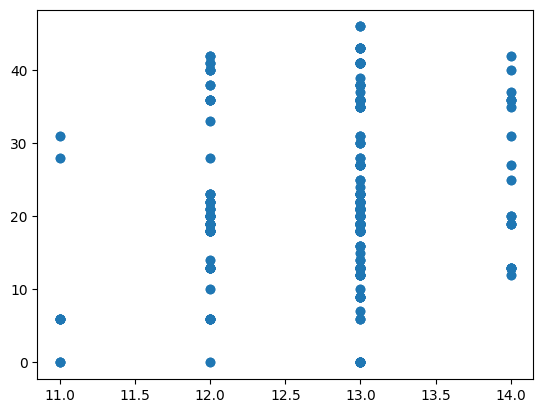

In [56]:
plt.plot(df['Error'], df['Pred_len'], 'o')

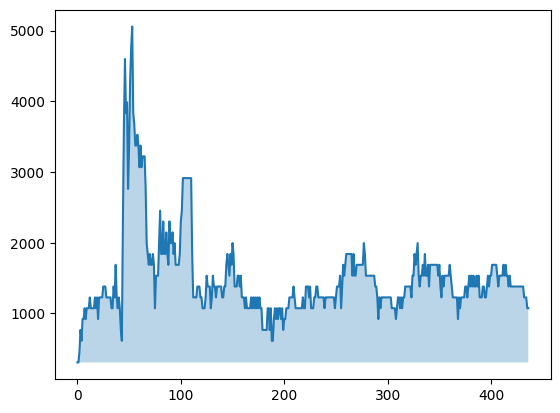

In [2]:
# all_ue_dicts
# latency
# wer_scores
# adv_his

import re
f = open(log_file, "r")
unit = "mW"
inss, avgs = [], []
for line in f:
    r = re.compile('GPU (.+?)([ \.]|$)')
    patterns = re.findall(r, line)
    if not patterns:
        continue
    GPU_pair = patterns[0][0]
    ins, avg = GPU_pair.split('/')
    ins = int(ins.rstrip(unit))
    inss.append(ins)
    avg = int(avg.rstrip(unit))
    avgs.append(avg)


xx = np.arange(len(inss))
yy = np.array(inss)
plt.plot(xx, yy)
plt.fill_between(xx, yy, y2 = min(yy), alpha=0.3,)

plt.show()

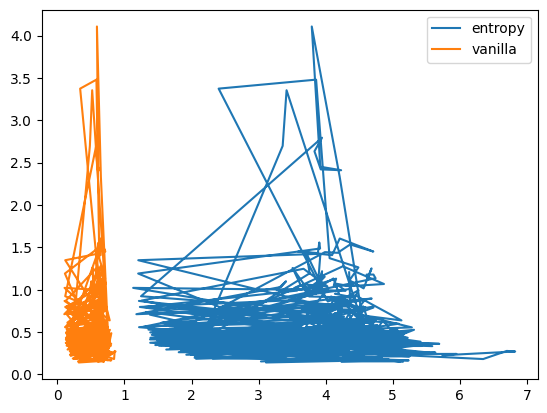

In [11]:
plt.plot([x["entropy"] for x in all_ue_dicts[1:]], latency[1:], label="entropy")
plt.plot([x["vanilla"] for x in all_ue_dicts[1:]], latency[1:], label="vanilla")
plt.legend()

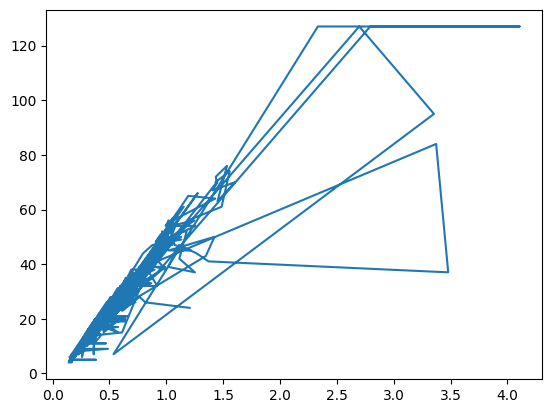

In [10]:
plt.plot(latency[1:], [x["pred_len"] for x in all_ue_dicts][1:], label="entropy")